In [5]:
import cv2
import numpy as np
import pandas as pd
import os
import seaborn as sns
from cv2 import MORPH_ELLIPSE
from matplotlib import pyplot as plt
from Codigos_F.funciones import get_min_max_feret_from_mask
from Codigos_F.funciones import superSlic, kmean, shift2, selContorno, selRegion, matrizConfusion, MedidasMC, similitud
from skimage.feature import graycomatrix, graycoprops

# PROCESAMIENTO IMAGEN INDIVIDUAL

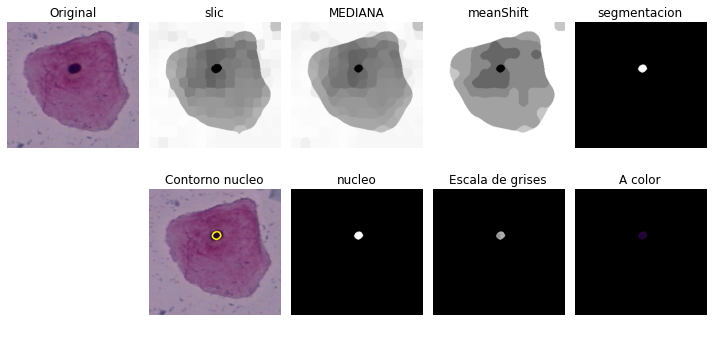

In [6]:
# RUTA DE LA IMAGEN
dirCarpeta = 'DatasetNormalizado/1_normal_superficiel/normalSup71.jpg'
#dirCarpeta = 'DatasetNormalizado/2_normal_intermediate/normalInter13.jpg'
#dirCarpeta = 'DatasetNormalizado/3_normal_columnar/normalCol65.jpg'
#dirCarpeta = 'DatasetNormalizado/4_light_dysplastic/anormalMild50.jpg'
#dirCarpeta = 'DatasetNormalizado/5_moderate_dysplastic/anormalMod64.jpg'
#dirCarpeta = 'DatasetNormalizado/6_severe_dysplastic/anormalSevere182.jpg'
#dirCarpeta = 'DatasetNormalizado/7_carcinoma_in_situ/anormalCIS68.jpg'

# PREPROCESAMIENTO
# BGR
imagen = cv2.imread(dirCarpeta)
#RGB
imagen = cv2.cvtColor(imagen,cv2.COLOR_BGR2RGB)
#GRIS
gris   = cv2.cvtColor(imagen,cv2.COLOR_RGB2GRAY)
img = imagen[:,:,1]


#aplicar superpixeles------------------------------
slic = 1
if slic == 1:
    img = imagen.copy()
    #img = cv2.GaussianBlur(img,(21,21),cv2.BORDER_DEFAULT)
    img = cv2.medianBlur(img,21)
    img = superSlic(img)
    titleSlic = 'slic'
else:
    img = img.copy()
    titleSlic = 'sin Slic'

# #Porcentaje en el que se redimensiona la imagen
# porcentaje = 100
# #calcular el 50 por ciento de las dimensiones originales
# ancho = int(img.shape[1] * porcentaje / 100)
# alto = int(img.shape[0] * porcentaje / 100)
# img = cv2.resize(img, dsize=(ancho,alto))

# filtrado------------------------------------------
opcion = 1
if opcion == 1:
    mediana  = cv2.medianBlur(img,17)
    filtro = mediana
    tituloFiltro = 'MEDIANA'

if opcion == 2:
    bilateral = cv2.bilateralFilter(img,0,40,25)
    filtro = bilateral
    tituloFiltro = 'BILATERAL'

if opcion == 3:
    media = cv2.blur(img,(17,17))
    filtro = media
    tituloFiltro = 'MEDIA'

if opcion == 4:
    gaussiano = cv2.GaussianBlur(img,(17,17),cv2.BORDER_DEFAULT)
    filtro = gaussiano
    tituloFiltro = 'GAUSSIANO'

if opcion == 0:
    filtro = img
    tituloFiltro = 'SIN FILTRO'


# aplanar la imagen
pixelsValues =filtro.reshape(-1,1)
pixelsValues = np.float32(pixelsValues)


#agrupamiento de agrupamiento--------------------------------

opcionAgrup = 1

if opcionAgrup == 1:
    segmentacionImagen = shift2(pixelsValues,filtro)
    tituloSeg = 'meanShift'

elif opcionAgrup == 2:
    segmentacionImagen = kmean(pixelsValues,6,filtro)
    tituloSeg = 'kmean'
    
else:
    segmentacionImagen = filtro
    tituloSeg = 'sin Agrupamiento'



# nucleos
umbral = np.min(segmentacionImagen)
#umbral = umbral+33
umbral= umbral +10
#thresh = segmentacionImagen < umbral
#umbral = umbral
imagen2 = imagen.copy()

# #Porcentaje en el que se redimensiona la imagen
# porcentaje = 100
# #calcular el 50 por ciento de las dimensiones originales
# ancho = int(imagen2.shape[1] * porcentaje / 100)
# alto = int(imagen2.shape[0] * porcentaje / 100)
# imagen2 = cv2.resize(imagen2, dsize=(ancho,alto))


_,thresh = cv2.threshold(segmentacionImagen,umbral, 255, cv2.THRESH_BINARY_INV)
#operaciones morfológicas
kernel = cv2.getStructuringElement(MORPH_ELLIPSE,ksize=(5,5))
thresh = cv2.erode(thresh, kernel, iterations=1)
thresh = cv2.dilate(thresh,kernel, iterations=1)

contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contorno,cx,cy = selContorno(contours,thresh)
cv2.drawContours(imagen2, contours, contorno, (255,255,0), 2);

#seleccionador de regiones
area = cv2.contourArea(contours[contorno])
_, label, _,centroids = cv2.connectedComponentsWithStats(thresh)
imagenReg = selRegion(label,area)
#imagenReg = selRegion(thresh)
imagenReg[imagenReg > 200] = 255
imagenReg[imagenReg != 255] = 0

# Imagen en escala grises y color 
imgColor = imagen.copy()
for fila in range (gris.shape[0]):
    for columna in range (gris.shape[1]):
        if imagenReg[fila][columna] == 0:
            gris[fila][columna] = 0
            imgColor[fila][columna] = 0
        else:
            pass

#graficar
fig, ax = plt.subplots(2,5,figsize=(10, 5), sharex=True, sharey=True)

ax[0,0].imshow(imagen)
ax[0,0].set_title('Original')
ax[0,0].axis(False)
ax[0,1].imshow(img,'gray')
ax[0,1].set_title(titleSlic)
ax[0,1].axis(False)
ax[0,2].imshow(filtro,'gray')
ax[0,2].set_title(tituloFiltro)
ax[0,2].axis(False)
ax[0,3].imshow(segmentacionImagen,'gray')
ax[0,3].set_title(tituloSeg)
ax[0,3].axis(False)
ax[0,4].imshow(thresh,'gray')
ax[0,4].set_title('segmentacion')
ax[0,4].axis(False)
ax[1,0].axis(False)
ax[1,1].imshow(imagen2,'gray')
ax[1,1].set_title('Contorno nucleo')
ax[1,1].axis(False)
ax[1,2].imshow(imagenReg,'gray')
ax[1,2].set_title('nucleo')
ax[1,2].axis(False)
ax[1,3].imshow(gris,'gray')
ax[1,3].set_title('Escala de grises')
ax[1,3].axis(False)
ax[1,4].imshow(imgColor,'gray')
ax[1,4].set_title('A color')
ax[1,4].axis(False)
    
plt.tight_layout()
plt.show()


# procesamiento de imagenes para todas las células

El preprocesamiento consiste en los siguientes pasos:<br>
1. Filtrado
2. Generación de Superpíxeles
3. Agrupación por el método de MeanShift
4. Extracción de Nucleo
5. umbralización
6. Detección de bordes
7. Métricas de Segmentación
8. Caracteristicas morfológicas y de textura

In [ ]:
#metricas de evaluacion
clase =[]
celula = []
vPos = []
vNeg = []
fPos = []
fNeg = []
pres = []
reCall = []
exact = []
senRuid = []
medF = []
tasError = []
tasNeg = []
jac = []
dice = []
#características morfológicas
are = []
perimetro = []
circularidad = []
radio = []
eje1 = []
eje2 = []
relacion = []
extension = []
solidez = []
diamEqui = []
excentricidad = []
relacionFeret = []


#características de textura
brillo = []
correlacion = []
contraste = []
disimilitud = []
homogeneidad = []
ASM = []
energia = []
entropia = []

correlacion2 = []
contraste2 = []
disimilitud2 = []
homogeneidad2 = []
ASM2 = []
energia2 = []
entropia2 = []

correlacion3 = []
contraste3 = []
disimilitud3 = []
homogeneidad3 = []
ASM3 = []
energia3 = []
entropia3 = []

#matriz de características
caractNucleo = pd.DataFrame()
#tabla  de metricas de evaluacion
medidasDf = pd.DataFrame()
#archivos de la imagen
dirCarpeta1 = 'DatasetNormalizado/1_normal_superficiel'
dirCarpeta2 = 'DatasetNormalizado/2_normal_intermediate'
dirCarpeta3 = 'DatasetNormalizado/3_normal_columnar'
dirCarpeta4 = 'DatasetNormalizado/4_light_dysplastic'
dirCarpeta5 = 'DatasetNormalizado/5_moderate_dysplastic'
dirCarpeta6 = 'DatasetNormalizado/6_severe_dysplastic'
dirCarpeta7 = 'DatasetNormalizado/7_carcinoma_in_situ'

dirCarpetaImg = [dirCarpeta1, dirCarpeta2, dirCarpeta3, dirCarpeta4, dirCarpeta5,dirCarpeta6,dirCarpeta7]
#dirCarpetaImg = [dirCarpeta1]
for ind, dirCarpeta in enumerate(dirCarpetaImg):
        
    archivos = os.listdir(dirCarpeta)
    archivos = archivos[0:]
    nombreColumna = ['1','2','3','4','5','6','7','8','9']


    fig, ax = plt.subplots(len(archivos),len(nombreColumna))
    fig.set_size_inches(35,300)
    fig.suptitle('SEGMENTACION'+dirCarpeta[18:])

    for i,e in enumerate(archivos):
        #imagen a procesar
        dirImg = dirCarpeta+'/'+e
        #imagen de referencia
        dirImgRef = 'DatasetNormalizado/REFERENCIA/'+dirImg[19:]
        #Lectura de Imágen a procesar
        imagen = cv2.imread(dirImg)
        #Lectura de imagen de referencia
        imagenRef = cv2.imread(dirImgRef)
        
        #IMAGEN A PROCESAR
        #conversion a RGB
        imagen = cv2.cvtColor(imagen,cv2.COLOR_BGR2RGB)
        #GRIS
        gris   = cv2.cvtColor(imagen,cv2.COLOR_RGB2GRAY)

        img = imagen[:,:,1]
        #clahe = cv2.createCLAHE(clipLimit=5)
        #img = clahe.apply(img) + 10
        #img = cv2.medianBlur(img,11)
        
        

        #aplicar superpixeles---------------------------------------------------
        slic = 1
        if slic == 1:
            img = imagen.copy()
            img = cv2.medianBlur(img,21)
            img = superSlic(img)
            titleSlic = 'slic'
            
        else:
            img = img.copy()
            titleSlic = 'sin slic'

        # FILTRADO-------------------------------------------------------------
        opcion = 1
        if opcion == 1:
            mediana  = cv2.medianBlur(img,17)
            filtro = mediana
            tituloFiltro = 'MEDIANA'
        elif opcion == 2:
            bilateral = cv2.bilateralFilter(img,0,40,25)
            filtro = bilateral
            tituloFiltro = 'BILATERAL'
        elif opcion == 3:
            media = cv2.blur(img,(11,11))
            filtro = media
            tituloFiltro = 'MEDIA'
        elif opcion == 4:
            gaussiano = cv2.GaussianBlur(img,(11,11),cv2.BORDER_DEFAULT)
            filtro = gaussiano
            tituloFiltro = 'GAUSSIANO'
        elif opcion == 0:
            filtro = img
            tituloFiltro = 'SIN FILTRO'

        # aplanar la imagen
        pixelsValues =filtro.reshape(-1,1)
        pixelsValues = np.float32(pixelsValues)


        #CLUSTERING-----------------------------------------------

        opcionAgrup = 1

        if opcionAgrup == 1:
            segmentacionImagen = shift2(pixelsValues,filtro)
            #segmentacionImagen = cv2.threshold(segmentacionImagen,140,255,cv2.THRESH_TOZERO)
            tituloSeg = 'meanShift'

        elif opcionAgrup == 2:
            segmentacionImagen = kmean(pixelsValues,6,filtro)
            tituloSeg = 'kmean'

        elif opcionAgrup == 0:
            segmentacionImagen = filtro
        

        # SEGMENTACION DE NUCLEO---------------------------------------------------------------------
        opcionNucleo = 1
        if opcionNucleo == 1:
            umbral = np.min(segmentacionImagen)
            #umbral = umbral+33
            umbral= umbral +10
            #thresh = segmentacionImagen < umbral
            #umbral = umbral
            ret, thresh = cv2.threshold(segmentacionImagen,umbral, 255, cv2.THRESH_BINARY_INV)
            #operaciones morfológicas
            kernel = cv2.getStructuringElement(MORPH_ELLIPSE,ksize=(5,5))
            thresh = cv2.erode(thresh, kernel, iterations=1)
            thresh = cv2.dilate(thresh,kernel, iterations=1)

        else :
            thresh = segmentacionImagen



        opcionSel = 1
        if opcionSel == 1:
            # selecion de núcleos
            imagen2 = imagen.copy()
            contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            contorno,cx,cy = selContorno(contours,thresh)
            cv2.drawContours(imagen2, contours, contorno, (255,255,0), 2);
        elif opcionSel == 0:
            imagen2 = gris.copy()

        opcionReg = 1
        if opcionReg == 1:
            #seleccionador de regiones
            area = cv2.contourArea(contours[contorno])
            retval, label, stats,centroids = cv2.connectedComponentsWithStats(thresh)
            imagenReg = selRegion(label,area);
        
            imagenReg[imagenReg > 200] = 255
            imagenReg[imagenReg != 255] = 0
            

        #Metricas de evaluacion
        opcionEval = 1
        if opcionEval == 1:
            #tratamiento de imagen de referencia
            imagenRef = np.uint8(imagenRef[:,:,0])
            imagenRef[imagenRef >= 200] = 255
            imagenRef[imagenRef != 255] = 0

            FN,FP,VP,VN = matrizConfusion(imagenReg,imagenRef)
            P,R,E,NSR,FM,ER,NRM = MedidasMC(VP,VN,FP,FN)
            sim = similitud(imagenReg,imagenRef)
            jac.append(sim[0])
            dice.append(sim[1])
            clase.append(dirCarpeta[19:20])
            celula.append(e)
            vPos.append(VP)
            vNeg.append(VN)
            fPos.append(FP)
            fNeg.append(FN)
            pres.append(P)
            reCall.append(R)
            exact.append(E)
            senRuid.append(NSR)
            medF.append(FM)
            tasError.append(ER)
            tasNeg.append(NRM)

        opcionCaract = 1
        if opcionCaract == 1:
            imgColor = imagen.copy()
            for fila in range (gris.shape[0]):
                for columna in range (gris.shape[1]):
                    if imagenReg[fila][columna] == 0:
                        gris[fila][columna] = 0
                        imgColor[fila][columna] = 0
                    else:
                        pass
            #CARACTERISTICAS MORFOLOGICAS
            #area
            ar = cv2.contourArea(contours[contorno])
            #perimetro
            per = cv2.arcLength(contours[contorno],True)
            #circularidad
            cir =  (4*np.pi* ar)/(per**2)
            #radio
            rad = np.sqrt(ar/np.pi)
            #ejes   (eje[1]--->diametro mayor, eje[0]--->diametro menor)
            ejes = get_min_max_feret_from_mask(imagenReg)
            #relacion de aspecto
            x,y,w,h = cv2.boundingRect(contours[contorno])
            aspecto = float(w)/h
            #relacion de aspecto feret
            #ejes = get_min_max_feret_from_mask(imagenReg)
            aspectoFeret = (ejes[1])/(ejes[0])
            #excentricidad, respecto al elipse
            c,l,angle= cv2.fitEllipse(contours[contorno])
            a = max(l) #eje mayor
            b = min(l) #eje menor
            excen = np.sqrt(1+((b*2)/(a*2)))
            #extension
            rect_area = w*h
            exten = float(ar)/rect_area
            # solidez
            hull = cv2.convexHull(contours[contorno])
            hull_area = cv2.contourArea(hull)
            solid = float(ar)/hull_area 

            # diametro equivalente
            equi_diametro = np.sqrt(4*ar/np.pi)          

            #CARACTERISTICAS DE TEXTURA
            # BRILLO
            R,G,B = cv2.split(imgColor)
            # adaptando los datos de cada espectro de color RGB
            Ru = R.reshape(-1,1 )
            Gu = G.reshape(-1,1 )
            Bu = B.reshape(-1,1 )
            # calculando el promedio 
            Ru=np.mean(Ru)
            Gu=np.mean(Gu)
            Bu=np.mean(Bu)
            #coeficientes 
            c=[0.299, 0.587, 0.114]
            # brightness / ecuación
            Y= (c[0]*Ru+c[1]*Gu+c[2]*Bu)

            #GCLM 1
            glcm = graycomatrix(gris,distances=[10],angles=[0],symmetric=True) #1
            corre = graycoprops(glcm,'correlation')
            corre = corre[0][0]
            contr = graycoprops(glcm,'contrast')
            contr = contr[0][0]
            disi = graycoprops(glcm,'dissimilarity')
            disi = disi[0][0]
            homog = graycoprops(glcm,'homogeneity')
            homog = homog[0][0]
            AS = graycoprops(glcm,'ASM')
            AS = AS[0][0]
            ener = graycoprops(glcm,'energy')
            ener = ener[0][0]
            entro =  -np.sum(glcm * np.log2(glcm + (glcm == 0)))
            #GCLM2
            glcm2 = graycomatrix(gris,distances=[20],angles=[45],symmetric=True) #1
            corre2 = graycoprops(glcm2,'correlation')
            corre2 = corre2[0][0]
            contr2 = graycoprops(glcm2,'contrast')
            contr2 = contr2[0][0]
            disi2 = graycoprops(glcm2,'dissimilarity',)
            disi2 = disi2[0][0]
            homog2 = graycoprops(glcm2,'homogeneity')
            homog2 = homog2[0][0]
            AS2 = graycoprops(glcm2,'ASM')
            AS2 = AS2[0][0]
            ener2 = graycoprops(glcm2,'energy')
            ener2 = ener2[0][0]
            entro2 = -np.sum(glcm2 * np.log2(glcm2 + (glcm2 == 0)))
            entro2 = -np.sum(glcm2 * np.log2(glcm2 + (glcm2 == 0)))
            #GCLM3
            glcm3 = graycomatrix(gris,distances=[30],angles=[90],symmetric=True) #1
            corre3 = graycoprops(glcm3,'correlation')
            corre3 = corre3[0][0]
            contr3 = graycoprops(glcm3,'contrast')
            contr3 = contr3[0][0]
            disi3 = graycoprops(glcm3,'dissimilarity')
            disi3 = disi3[0][0]
            homog3 = graycoprops(glcm3,'homogeneity')
            homog3 = homog3[0][0]
            AS3 = graycoprops(glcm3,'ASM')
            AS3 = AS3[0][0]
            ener3 = graycoprops(glcm3,'energy')
            ener3 = ener3[0][0]
            entro3 = -np.sum(glcm3 * np.log2(glcm3 + (glcm3 == 0)))
            #Llenar las listas con sus correspondientes caracteristicas
            #Morfológicas
            are.append(ar)
            perimetro.append(per)
            circularidad.append(cir)
            radio.append(rad)
            eje1.append(ejes[0])
            eje2.append(ejes[1])
            relacion.append(aspecto)
            extension.append(exten)
            solidez.append(solid)
            diamEqui.append(equi_diametro)
            brillo.append(Y)
            excentricidad.append(excen)
            relacionFeret.append(aspectoFeret)
            # textura 1
            correlacion.append(corre)
            contraste.append(contr)
            disimilitud.append(disi)
            homogeneidad.append(homog)
            ASM.append(AS)
            energia.append(ener)
            entropia.append(entro)
            # textura 2
            correlacion2.append(corre2)
            contraste2.append(contr2)
            disimilitud2.append(disi2)
            homogeneidad2.append(homog2)
            ASM2.append(AS2)
            energia2.append(ener2)
            entropia2.append(entro2)
            # textura 3
            correlacion3.append(corre3)
            contraste3.append(contr3)
            disimilitud3.append(disi3)
            homogeneidad3.append(homog3)
            ASM3.append(AS3)
            energia3.append(ener3)
            entropia3.append(entro3)

        # GRAFICAR LAS IMAGENES 
        #nucleo
        imagenTipo = [imagen,img,filtro,segmentacionImagen,thresh,imagen2,imagenReg,gris,imgColor]
        nombreColumna = ['ENTRADA',titleSlic,'FILTRO '+ tituloFiltro,'AGRUPAMIENTO '+tituloSeg,'NUCLEOS','SEGMENTACION','NUCLEO REGION','GRIS','COLOR']


        for j in range(0,len(imagenTipo)):
            ax[i,j].imshow(imagenTipo[j],'gray')
            ax[i,j].set(title=nombreColumna[j]+'-- ('+e+')')
            ax[i,j].axis('off')
plt.subplots_adjust(top=0.97)
plt.show()
#tabla de metricas
medidasDf['CLASE'] = clase
medidasDf['CELULA'] = celula
medidasDf['FN'] = fNeg
medidasDf['FP'] = fPos
medidasDf['VP'] = vPos
medidasDf['VN'] = vNeg
medidasDf['P'] = pres
medidasDf['R'] = reCall
medidasDf['E'] = exact
medidasDf['NSR'] = senRuid
medidasDf['FM'] = medF
medidasDf['ER'] = tasError
medidasDf['NRM'] = tasNeg
medidasDf['JACC'] = jac
medidasDf['DICE'] = dice

#matriz de características
caractNucleo['CLASE'] = clase
caractNucleo['CELULA'] = celula
caractNucleo['AREA'] = are
caractNucleo['PERIMETRO'] = perimetro
caractNucleo['CIRCULARIDAD'] = circularidad
caractNucleo['RADIO'] = radio
caractNucleo['EJE1'] = eje1
caractNucleo['EJE2'] = eje2
caractNucleo['RELACION'] = relacion
caractNucleo['EXTENSION'] = extension
caractNucleo['SOLIDEZ'] = solidez
caractNucleo['DIAMEQUI'] = diamEqui
caractNucleo['BRILLO'] = brillo
caractNucleo['EXCENTRICIDAD'] = excentricidad
caractNucleo['RELACIONFERET'] = aspectoFeret

caractNucleo['CORRELACION'] = correlacion
caractNucleo['CONTRASTE'] = contraste
caractNucleo['DISIMILITUD'] = disimilitud
caractNucleo['HOMOGENEIDAD'] = homogeneidad
caractNucleo['ASM'] = ASM
caractNucleo['ENERGIA'] = energia
caractNucleo['ENTROPIA'] = entropia

caractNucleo['CORRELACION2'] = correlacion2
caractNucleo['CONTRASTE2'] = contraste2
caractNucleo['DISIMILITUD2'] = disimilitud2
caractNucleo['HOMOGENEIDAD2'] = homogeneidad2
caractNucleo['ASM2'] = ASM2
caractNucleo['ENERGIA2'] = energia2
caractNucleo['ENTROPIA2'] = entropia2

caractNucleo['CORRELACION3'] = correlacion3
caractNucleo['CONTRASTE3'] = contraste3
caractNucleo['DISIMILITUD3'] = disimilitud3
caractNucleo['HOMOGENEIDAD3'] = homogeneidad3
caractNucleo['ASM3'] = ASM3
caractNucleo['ENERGIA3'] = energia3
caractNucleo['ENTROPIA3'] = entropia3



Exportar las métricas y las caracteristicas de las células a archivos CSV con toda la información.

In [ ]:
# exportar las métricas y las características como archivo CSV
medidasDf.to_csv('evalNucleoMeanShift.csv',encoding='utf-8',sep=';')
caractNucleo.to_csv('caractNucleoShift.csv',encoding='utf-8',sep=';')

# Evaluación de la segmentación célular

In [8]:
datos  = pd.read_csv('Arhivos CSV/evalNucleoMeanShift.csv',sep=';',index_col=0)
datos.head()

,CLASE,CELULA,FN,FP,VP,VN,P,R,E,NSR,FM,ER,NRM,JACC,DICE
0,1,normalSup1.jpg,250,0,549,43427,1.000000,0.687109,0.994347,0.000000,0.814540,0.000000,0.156446,0.687109,0.814540
1,1,normalSup10.jpg,246,0,396,107114,1.000000,0.616822,0.997717,0.000000,0.763006,0.000000,0.191589,0.616822,0.763006
2,1,normalSup11.jpg,270,0,430,85430,1.000000,0.614286,0.996865,0.000000,0.761062,0.000000,0.192857,0.614286,0.761062
3,1,normalSup12.jpg,157,2,547,72122,0.996357,0.776989,0.997817,0.003656,0.873105,0.002841,0.112926,0.774788,0.873105
4,1,normalSup13.jpg,351,0,265,46340,1.000000,0.430195,0.992525,0.000000,0.601589,0.000000,0.284903,0.430195,0.601589


Promedio de las metricas por cada una de las clases que fueron segmentadas.

In [9]:
df1 = pd.DataFrame(columns=['CLASE', 'P', 'R', 'FM', 'DICE'])
for i in range(1, 8):
    clase_data = datos.loc[datos.CLASE == i]
    clase_mean = clase_data.groupby('CLASE').mean().reset_index()
    df1 = pd.concat([df1, clase_mean], ignore_index=True)

df1['CLASE'] = df1['CLASE'].astype(str)
df1

,CLASE,P,R,FM,DICE,FN,FP,VP,VN,E,NSR,ER,NRM,JACC
0,1,0.899331,0.667966,0.748864,0.728624,198.891892,534.013514,427.918919,101467.148649,0.978779,1.173079,1.145342,0.738688,0.605549
1,2,0.884381,0.72124,0.873263,0.785937,364.814286,73.085714,944.257143,77490.285714,0.993760,0.018747,0.050821,0.164791,0.708837
2,3,0.782194,0.786187,0.775317,0.743672,325.653061,653.163265,1258.612245,7209.428571,0.892898,0.449325,0.428095,0.320954,0.631568
3,4,0.795443,0.704794,0.839433,0.719514,1532.785714,574.302198,3145.131868,26783.615385,0.928050,0.155564,0.138919,0.217062,0.649751
4,5,0.82718,0.758864,0.82602,0.763786,977.972603,622.643836,2883.883562,13311.424658,0.903109,0.204236,0.173325,0.207231,0.679038
5,6,0.842522,0.744692,0.806973,0.76601,813.832487,443.664975,2125.335025,6398.918782,0.863710,2.277240,0.195101,0.225205,0.663361
6,7,0.820046,0.752253,0.806333,0.763329,726.806667,471.053333,2248.973333,4182.926667,0.833294,0.208160,0.175830,0.211788,0.654555


Drescripcion general de la segmentación célular

In [10]:
datos.describe()

,CLASE,FN,FP,VP,VN,P,R,E,NSR,FM,ER,NRM,JACC,DICE
count,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,849.000000,849.000000,917.000000,917.000000,917.000000,917.000000
mean,4.577972,832.351145,503.960742,2148.970556,24368.075245,0.828391,0.736719,0.900110,0.748082,0.812345,0.267900,0.265590,0.657124,0.752106
std,1.816252,1359.800607,1607.447754,1680.876468,35030.800603,0.292908,0.272678,0.115785,12.843344,0.163454,1.783042,0.890158,0.261725,0.264745
min,1.000000,0.000000,0.000000,0.000000,429.000000,0.000000,0.000000,0.248762,0.000000,0.000912,0.000000,0.017373,0.000000,0.000000
25%,3.000000,169.000000,0.000000,959.000000,4441.000000,0.816647,0.657955,0.858804,0.000000,0.757897,0.000000,0.077280,0.566697,0.723429
50%,5.000000,336.000000,44.000000,1840.000000,9158.000000,0.980046,0.827856,0.942931,0.014734,0.857785,0.016310,0.144551,0.730076,0.843982
75%,6.000000,815.000000,372.000000,3020.000000,26683.000000,1.000000,0.928099,0.979551,0.146970,0.924937,0.128840,0.261857,0.850236,0.919057
max,7.000000,9586.000000,27577.000000,10053.000000,229608.000000,1.000000,1.000000,0.999642,370.222222,0.982420,39.503984,19.751992,0.965448,0.982420


# Etiquetado de cada célula según las distintas nomenclaturas.

In [11]:
#2 Clases(normal,Anormal)
binario = []
for ind, ele in enumerate(datos['CLASE']):
    if ele == 1 or ele == 2 or ele == 3:
        binario.append('1_NORMAL')
    if ele == 4 or ele == 5 or ele == 6 or ele == 7:
        binario.append('2_ANORMAL')
datos['BIN'] = binario

# tres clases,  Corriente citologíca
#normal, lsil,hsil
cytology = []
for ind, ele in enumerate(datos['CLASE']):
    if ele == 1 or ele == 2 or ele == 3:
         cytology.append('1_NORMAL')
    if ele == 4:
        cytology.append('2_LSIL')
    if ele == 5 or ele == 6 or ele == 7:
        cytology.append('3_HSIL')
datos['CYT'] = cytology


# cuatro  clases, corriente Histológica
#normal, CIN1,CIN2,CIN3
cytology = []
for ind, ele in enumerate(datos['CLASE']):
    if ele == 1 or ele == 2 or ele == 3:
         cytology.append('1_NORMAL')
    if ele == 4:
        cytology.append('2_CIN1')
    if ele == 5:
        cytology.append('3_CIN2')
    if ele == 6 or ele == 7:
        cytology.append('4_CIN3')
datos['HIST'] = cytology

Analisis de tendencia central

(0.0, 1.0)

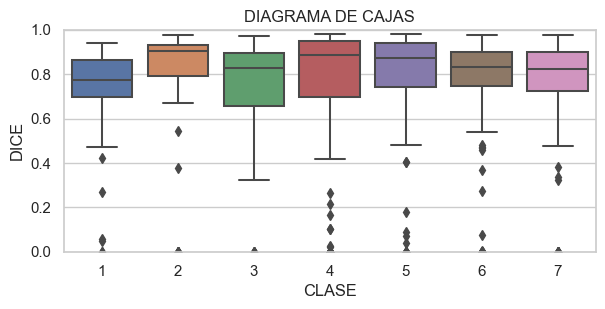

In [12]:
plt.figure(figsize=(7,3),dpi=98)
sns.set(style='whitegrid')
sns.boxplot(x="CLASE",y="DICE",data=datos)
plt.title('DIAGRAMA DE CAJAS')
plt.ylim((0,1))

(0.0, 1.0)

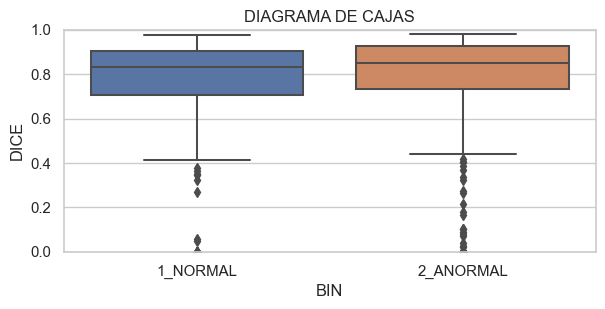

In [13]:
plt.figure(figsize=(7,3),dpi=98)
sns.set(style='whitegrid')
sns.boxplot(x="BIN",y="DICE",data=datos)
plt.title('DIAGRAMA DE CAJAS')
plt.ylim((0,1))